### Each Row Represents A Crime 

***Visualizations***
- the areas with the most crime
- what crimes are most popular per area 
- A heat map per area that shows popularity of each crime 
    - Another based on time per hour of day
    - Another per week, per month
- split the city maps based on each crime 

***ML Models***
- clustering?
- time series?

***Production***
- use pyspark & airflow
- add pipeline to cloud service to constantly update data, transform, and add model information serve POWER BI

### Import Dataset

The LA Crime dataset can be found in the following sources:
- https://dev.socrata.com/foundry/data.lacity.org/2nrs-mtv8
- https://www.kaggle.com/cityofLA/crime-in-los-angeles
- https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8

"This dataset reflects incidents of crime in the City of Los Angeles dating back to 2020. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data. Some location fields with missing data are noted as (0°, 0°). Address fields are only provided to the nearest hundred block in order to maintain privacy. This data is as accurate as the data in the database. Please note questions or concerns in the comments."

In [128]:
from sodapy import Socrata #importing dataset
import yaml #to sort API keys

import pandas as pd 
import datetime
from dateutil.relativedelta import relativedelta

import seaborn as sns #data visualizations

I use chose to use a configuration file to hide my apptoken, username, and password which are needed inorder to connect to the Socrata API. The steps to create an apptoken can be found here https://dev.socrata.com/foundry/data.lacity.org/2nrs-mtv8

In [55]:
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

In [59]:
client = Socrata("data.lacity.org",
                 cfg['apptoken'],
                 username=cfg['username'],
                 password=cfg['password'])

We want to narrow our analysis to the last three months of reported crimes

In [21]:
three_month = datetime.datetime.now() + relativedelta(months=-3)
date_str = f"'{three_month.isoformat()}'"
date_str

"'2021-10-25T22:21:22.369071'"

In [42]:
results = client.get("2nrs-mtv8", where="date_rptd > " + date_str, limit = 100000)
results_df = pd.DataFrame.from_records(results) #pandas dataframe
results_df.head()

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,...,status,status_desc,crm_cd_1,location,lat,lon,cross_street,crm_cd_2,crm_cd_3,crm_cd_4
0,210216655,2021-10-26T00:00:00.000,2020-10-09T00:00:00.000,0100,02,Rampart,0246,1,121,"RAPE, FORCIBLE",...,IC,Invest Cont,121,400 S WESTLAKE AV,34.059,-118.2737,NaN,NaN,NaN,NaN
1,210515312,2021-10-26T00:00:00.000,2020-07-20T00:00:00.000,0001,05,Harbor,0557,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,IC,Invest Cont,341,800 W 5TH ST,33.7397,-118.2946,NaN,NaN,NaN,NaN
2,211013798,2021-10-26T00:00:00.000,2020-01-11T00:00:00.000,1110,10,West Valley,1003,2,662,"BUNCO, GRAND THEFT",...,IC,Invest Cont,662,7600 RESEDA BL,34.2148,-118.5404,NaN,NaN,NaN,NaN
3,211819149,2021-10-26T00:00:00.000,2020-08-20T00:00:00.000,1800,18,Southeast,1841,2,822,HUMAN TRAFFICKING - COMMERCIAL SEX ACTS,...,IC,Invest Cont,822,FIGUEROA ST,33.9401,-118.2826,106TH ST,NaN,NaN,NaN
4,210515522,2021-10-26T00:00:00.000,2020-01-01T00:00:00.000,0600,05,Harbor,0522,2,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,...,IC,Invest Cont,627,700 GULF AV,33.778,-118.2728,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52677,221305072,2022-01-24T00:00:00.000,2022-01-24T00:00:00.000,0150,13,Newton,1353,1,236,INTIMATE PARTNER - AGGRAVATED ASSAULT,...,IC,Invest Cont,236,800 E 46TH ST,34.0016,-118.2617,NaN,NaN,NaN,NaN
52678,221104869,2022-01-24T00:00:00.000,2022-01-24T00:00:00.000,1115,11,Northeast,1151,1,761,BRANDISH WEAPON,...,IC,Invest Cont,761,1500 N VERMONT AV,34.0986,-118.2962,NaN,NaN,NaN,NaN
52679,220304998,2022-01-24T00:00:00.000,2022-01-24T00:00:00.000,1315,03,Southwest,0377,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624,1100 W 39TH ST,34.0155,-118.2978,NaN,NaN,NaN,NaN
52680,221104862,2022-01-24T00:00:00.000,2022-01-18T00:00:00.000,1800,11,Northeast,1145,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510,2400 RIVERSIDE DR,34.1049,-118.2545,NaN,NaN,NaN,NaN


In [134]:
df = results_df

In [135]:
def expand_print(lst):
    for i in lst: print(i)

In [40]:
results_all = client.get_all("2nrs-mtv8", where="date_rptd > " + date_str) #all the data as a generator 

### Data Cleaning

In [80]:
results_df.head()

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,...,status,status_desc,crm_cd_1,location,lat,lon,cross_street,crm_cd_2,crm_cd_3,crm_cd_4
0,210216655,2021-10-26T00:00:00.000,2020-10-09T00:00:00.000,0100,02,Rampart,0246,1,121,"RAPE, FORCIBLE",...,IC,Invest Cont,121,400 S WESTLAKE AV,34.059,-118.2737,NaN,NaN,NaN,NaN
1,210515312,2021-10-26T00:00:00.000,2020-07-20T00:00:00.000,0001,05,Harbor,0557,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,IC,Invest Cont,341,800 W 5TH ST,33.7397,-118.2946,NaN,NaN,NaN,NaN
2,211013798,2021-10-26T00:00:00.000,2020-01-11T00:00:00.000,1110,10,West Valley,1003,2,662,"BUNCO, GRAND THEFT",...,IC,Invest Cont,662,7600 RESEDA BL,34.2148,-118.5404,NaN,NaN,NaN,NaN
3,211819149,2021-10-26T00:00:00.000,2020-08-20T00:00:00.000,1800,18,Southeast,1841,2,822,HUMAN TRAFFICKING - COMMERCIAL SEX ACTS,...,IC,Invest Cont,822,FIGUEROA ST,33.9401,-118.2826,106TH ST,NaN,NaN,NaN
4,210515522,2021-10-26T00:00:00.000,2020-01-01T00:00:00.000,0600,05,Harbor,0522,2,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,...,IC,Invest Cont,627,700 GULF AV,33.778,-118.2728,NaN,NaN,NaN,NaN


In [44]:
results_df.dtypes

dr_no             object
date_rptd         object
date_occ          object
time_occ          object
area              object
area_name         object
rpt_dist_no       object
part_1_2          object
crm_cd            object
crm_cd_desc       object
mocodes           object
vict_age          object
vict_sex          object
vict_descent      object
premis_cd         object
premis_desc       object
weapon_used_cd    object
weapon_desc       object
status            object
status_desc       object
crm_cd_1          object
location          object
lat               object
lon               object
cross_street      object
crm_cd_2          object
crm_cd_3          object
crm_cd_4          object
dtype: object

In [77]:
expand_print(df.columns[df.isnull().any()])

mocodes
vict_sex
vict_descent
premis_cd
premis_desc
weapon_used_cd
weapon_desc
crm_cd_1
cross_street
crm_cd_2
crm_cd_3
crm_cd_4


In [112]:
max(results_df['date_rptd'])

'2022-01-24T00:00:00.000'

In [110]:
min(results_df['date_rptd'])

'2021-10-26T00:00:00.000'

In [113]:
len(df) #52 thousand record 

52682

### Data Visualization

In [136]:
expand_print(df["crm_cd_desc"])

RAPE, FORCIBLE
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
BUNCO, GRAND THEFT
HUMAN TRAFFICKING - COMMERCIAL SEX ACTS
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
THEFT OF IDENTITY
RAPE, FORCIBLE
THEFT OF IDENTITY
INTIMATE PARTNER - SIMPLE ASSAULT
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
THEFT OF IDENTITY
BATTERY WITH SEXUAL CONTACT
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
INTIMATE PARTNER - SIMPLE ASSAULT
ROBBERY
VEHICLE - STOLEN
BURGLARY FROM VEHICLE
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
VIOLATION OF RESTRAINING ORDER
ROBBERY
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BATTERY - SIMPLE ASSAULT
VEHICLE - STOLEN
VIOLATION OF RESTRAINING ORDER
BURGLARY FROM VEHICLE
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
CHILD STEALING
BUNCO, GRAND THEFT
ATTEMPTED ROBBERY
KIDNAPPING
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
THEFT OF IDENTITY
INTIMATE PARTNER - AGGRAVATED ASSAULT
VEHICLE - STOLEN
BURGLARY
BURGLARY FROM VEHICLE
VANDALISM - FEL

INTIMATE PARTNER - SIMPLE ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT, PERSON
CRIMINAL THREATS - NO WEAPON DISPLAYED
THEFT OF IDENTITY
BURGLARY FROM VEHICLE
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
ROBBERY
INTIMATE PARTNER - SIMPLE ASSAULT
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - STOLEN
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
BATTERY - SIMPLE ASSAULT
VEHICLE - STOLEN
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
THEFT PLAIN - PETTY ($950 & UNDER)
VEHICLE - STOLEN
VIOLATION OF COURT ORDER
DISCHARGE FIREARMS/SHOTS FIRED
THEFT OF IDENTITY
BURGLARY
INTIMATE PARTNER - SIMPLE ASSAULT
THEFT OF IDENTITY
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
VEHICLE - STOLEN
VIOLATION OF RESTRAINING ORDER
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - STOLEN
VEHICLE - STOLEN
VEHICLE - STOLEN
V

THEFT PLAIN - PETTY ($950 & UNDER)
BURGLARY FROM VEHICLE
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
THEFT OF IDENTITY
BURGLARY FROM VEHICLE
BIKE - STOLEN
THEFT OF IDENTITY
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
INTIMATE PARTNER - AGGRAVATED ASSAULT
DISTURBING THE PEACE
BURGLARY FROM VEHICLE
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
BURGLARY
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
BURGLARY FROM VEHICLE
BATTERY - SIMPLE ASSAULT
VIOLATION OF RESTRAINING ORDER
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VEHICLE - STOLEN
INTIMATE PARTNER - AGGRAVATED ASSAULT
ROBBERY
THEFT OF IDENTITY
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
VEHICLE - STOLEN
BATTERY - SIMPLE ASSAULT
VEHICLE - STOLEN
VEHICLE - STOLEN
VIOLATION OF RESTRAINING ORDER
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
BURGLARY FROM VEHICLE
CONTEMPT OF COURT
INTI

VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
RAPE, FORCIBLE
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
THEFT PLAIN - PETTY ($950 & UNDER)
BURGLARY FROM VEHICLE
VEHICLE - STOLEN
THEFT OF IDENTITY
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
BATTERY - SIMPLE ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT OF IDENTITY
BURGLARY FROM VEHICLE
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
OTHER ASSAULT
THEFT OF IDENTITY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
VEHICLE - STOLEN
ROBBERY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BIKE - STOLEN
BURGLARY
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
ROBBERY
BURGLARY FROM VEHICLE
BURGLARY
THEFT OF IDENTITY
THEFT OF IDENTITY
THEFT OF IDENTITY
BATTERY - SIMPLE ASSAULT
THEFT OF IDENTITY
INTIMATE PARTNER - SIMPLE ASSA

BURGLARY FROM VEHICLE
BURGLARY
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
INTIMATE PARTNER - AGGRAVATED ASSAULT
BURGLARY FROM VEHICLE
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
BURGLARY FROM VEHICLE
VEHICLE - STOLEN
VEHICLE - STOLEN
VEHICLE - STOLEN
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
INTIMATE PARTNER - SIMPLE ASSAULT
BATTERY - SIMPLE ASSAULT
RESISTING ARREST
THEFT OF IDENTITY
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VEHICLE - STOLEN
THEFT PLAIN - PETTY ($950 & UNDER)
VEHICLE - STOLEN
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
VEHICLE - STOLEN
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
BURGLARY FROM VEHICLE
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BURGLARY FROM VEHICLE
INTIMATE PARTNER - SIMPLE ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UN

BATTERY - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
INTIMATE PARTNER - AGGRAVATED ASSAULT
BURGLARY
BURGLARY
BATTERY WITH SEXUAL CONTACT
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
THEFT PLAIN - PETTY ($950 & UNDER)
INTIMATE PARTNER - AGGRAVATED ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT PLAIN - PETTY ($950 & UNDER)
VEHICLE - STOLEN
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
VIOLATION OF RESTRAINING ORDER
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
OTHER ASSAULT
VEHICLE - STOLEN
BURGLARY
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
BATTERY - SIMPLE ASSAULT
BIKE - STOLEN
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BURGLARY FROM VEHICLE
THEFT OF IDENTITY
THEFT OF IDENTITY
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER

INTIMATE PARTNER - AGGRAVATED ASSAULT
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
VIOLATION OF RESTRAINING ORDER
VEHICLE - STOLEN
VEHICLE - ATTEMPT STOLEN
VEHICLE - STOLEN
BUNCO, PETTY THEFT
BRANDISH WEAPON
BRANDISH WEAPON
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
VEHICLE - STOLEN
BATTERY - SIMPLE ASSAULT
BUNCO, GRAND THEFT
BURGLARY
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BATTERY - SIMPLE ASSAULT
THEFT OF IDENTITY
VEHICLE - STOLEN
BUNCO, GRAND THEFT
INTIMATE PARTNER - SIMPLE ASSAULT
ROBBERY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
INTIMATE PARTNER - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
BRANDISH WEAPON
INTIMATE PARTNER - SIMPLE ASSAULT
INTIMATE PARTNER - SIMPLE ASSAULT
BATTERY - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VEHICLE - STOLEN
CRIMINAL THREATS - NO WEAPON DISPLAYED
CRIMINAL THREATS - NO WEAPON DISPLAYED
BATT

VEHICLE - STOLEN
THEFT OF IDENTITY
ROBBERY
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
THEFT PLAIN - PETTY ($950 & UNDER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - STOLEN
ROBBERY
BURGLARY
BURGLARY
THEFT OF IDENTITY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT OF IDENTITY
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
THROWING OBJECT AT MOVING VEHICLE
TRESPASSING
THEFT PLAIN - PETTY ($950 & UNDER)
INTIMATE PARTNER - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - ATTEMPT STOLEN
THEFT PLAIN - PETTY ($950 & UNDER)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VIOLATION OF RESTRAINING ORDER
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
BATTERY - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
BURGLARY
THEFT OF IDENTITY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BATTERY - SIMPLE ASSAULT
THEFT OF IDENTITY
BURGLARY FROM VEHICLE
VANDAL

VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BATTERY - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
CRIMINAL THREATS - NO WEAPON DISPLAYED
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - STOLEN
VEHICLE - STOLEN
VEHICLE - STOLEN
THEFT OF IDENTITY
RAPE, FORCIBLE
VEHICLE - STOLEN
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
VEHICLE - ATTEMPT STOLEN
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
CONTEMPT OF COURT
INTIMATE PARTNER - SIMPLE ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
BIKE - STOLEN
THEFT OF IDENTITY
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
BURGLARY
VEHICLE - STOLEN
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
BATTERY - SIMPLE ASSAULT
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - GRAND ($95

BURGLARY FROM VEHICLE
BIKE - STOLEN
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
BURGLARY
BRANDISH WEAPON
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VEHICLE - STOLEN
OTHER ASSAULT
INTIMATE PARTNER - AGGRAVATED ASSAULT
THEFT OF IDENTITY
VEHICLE - STOLEN
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BATTERY - SIMPLE ASSAULT
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
BURGLARY
VEHICLE - STOLEN
VEHICLE - STOLEN
ROBBERY
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
BURGLARY
OTHER ASSAULT
VEHICLE - STOLEN
VEHICLE - STOLEN
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
INTIMATE PARTNER - AGGRAVATED ASSAULT
BURGLARY FROM VEHICLE
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
SHOTS FIRED AT INHABITED DWELLING
THEFT OF IDENTITY
OTHER MISCELLANEOUS CRIME
VIOLATION OF RESTRAINING ORDER
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - GRAN

VEHICLE - STOLEN
VEHICLE - STOLEN
INTIMATE PARTNER - AGGRAVATED ASSAULT
VEHICLE - STOLEN
BRANDISH WEAPON
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
INTIMATE PARTNER - AGGRAVATED ASSAULT
LEWD CONDUCT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
BATTERY - SIMPLE ASSAULT
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
VEHICLE - STOLEN
ROBBERY
ROBBERY
THEFT PLAIN - PETTY ($950 & UNDER)
VEHICLE - STOLEN
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
THEFT OF IDENTITY
CRIMINAL THREATS - NO WEAPON DISPLAYED
BATTERY - SIMPLE ASSAULT
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
THEFT FROM MOTOR VEHICLE 

THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
VEHICLE - STOLEN
VEHICLE - STOLEN
OTHER ASSAULT
VEHICLE - STOLEN
TRESPASSING
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
VEHICLE - STOLEN
VEHICLE - STOLEN
BATTERY - SIMPLE ASSAULT
LEWD CONDUCT
CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)
TRESPASSING
BATTERY - SIMPLE ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BRANDISH WEAPON
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - STOLEN
THEFT PLAIN - PETTY ($950 & UNDER)
CRIMINAL THREATS - NO WEAPON DISPLAYED
BURGLARY, ATTEMPTED
ROBBERY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BURGLARY FROM VEHICLE
THEFT OF IDENTITY
BATTERY - SIMPLE ASSAULT
THEFT OF IDENTITY
TRESPASSING
BUNCO, PETTY THEFT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BURGLARY
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED AS

ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VEHICLE - STOLEN
THEFT PLAIN - PETTY ($950 & UNDER)
INTIMATE PARTNER - SIMPLE ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
BATTERY - SIMPLE ASSAULT
THEFT OF IDENTITY
TRESPASSING
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
THEFT OF IDENTITY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - ATTEMPT STOLEN
ROBBERY
VEHICLE - STOLEN
CRIMINAL THREATS - NO WEAPON DISPLAYED
THEFT OF IDENTITY
THEFT FROM MOTOR VEHICLE - ATTEMPT
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)
BURGLARY
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
THEFT PLAIN - PETTY ($950 & UNDER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
ATTEMPTED ROBBERY
THEFT OF IDENTITY
BATTERY - SIMPLE ASSAULT
INTIMATE PARTNER - SIMPLE ASSAULT
THEFT OF IDENT

BURGLARY FROM VEHICLE
VEHICLE - STOLEN
BURGLARY
VEHICLE - STOLEN
THEFT OF IDENTITY
BURGLARY FROM VEHICLE
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
VEHICLE - STOLEN
VIOLATION OF RESTRAINING ORDER
BATTERY - SIMPLE ASSAULT
ATTEMPTED ROBBERY
THEFT OF IDENTITY
THEFT OF IDENTITY
CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
BURGLARY FROM VEHICLE
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
VEHICLE - STOLEN
BURGLARY FROM VEHICLE
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VIOLATION OF COURT ORDER
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
BURGLARY
THEFT OF IDENTITY
BURGLARY FROM VEHICLE
BATTERY - SIMPLE ASSAULT
VEHICLE - STOLEN
VEHICLE - STOLEN
THEFT OF IDENTITY
BATTERY WITH SEXUAL CONTACT
BURGLARY
BURGLARY
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
BURGLARY, ATTEMPTED
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
BURGLARY FROM VEHICLE
VIOLATION OF RESTRAINING ORDER
BURGLARY FROM VEHICLE
ASS

ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
INTIMATE PARTNER - SIMPLE ASSAULT
THEFT, PERSON
BURGLARY FROM VEHICLE
INTIMATE PARTNER - SIMPLE ASSAULT
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
OTHER MISCELLANEOUS CRIME
BURGLARY
THEFT PLAIN - PETTY ($950 & UNDER)
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
BIKE - STOLEN
VEHICLE - STOLEN
THEFT PLAIN - PETTY ($950 & UNDER)
VEHICLE - STOLEN
ROBBERY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
VEHICLE - STOLEN
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
VEHICLE - STOLEN
VANDALISM - FELONY ($400 & OVER, AL

THEFT PLAIN - PETTY ($950 & UNDER)
BATTERY - SIMPLE ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
BURGLARY FROM VEHICLE
INTIMATE PARTNER - SIMPLE ASSAULT
BATTERY WITH SEXUAL CONTACT
THEFT PLAIN - PETTY ($950 & UNDER)
VEHICLE - STOLEN
BURGLARY FROM VEHICLE
ROBBERY
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)
BURGLARY FROM VEHICLE
VEHICLE - STOLEN
BURGLARY FROM VEHICLE
INTIMATE PARTNER - SIMPLE ASSAULT
FAILURE TO YIELD
BURGLARY FROM VEHICLE
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BURGLARY
ROBBERY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VIOLATION OF COURT ORDER
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
INTIMATE PARTNER - SIMPLE ASSAULT
THEFT OF IDENTITY
THEFT OF IDENTITY
BURGLARY
INTIMATE PARTNER - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - STOLEN
CHILD PORNOGR

THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
VEHICLE - STOLEN
BURGLARY FROM VEHICLE
ROBBERY
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
INTIMATE PARTNER - AGGRAVATED ASSAULT
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
BATTERY - SIMPLE ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VEHICLE - STOLEN
BURGLARY
THEFT OF IDENTITY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BURGLARY
CHILD ANNOYING (17YRS & UNDER)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
DISCHARGE FIREARMS/SHOTS FIRED
INTIMATE PARTNER - SIMPLE ASSAULT
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
BATTERY - SIMPLE ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
BURGLARY
CRIMINAL THREATS - NO WEAPON DISPLAYED
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
OTHER MISCELLANEOUS CRIME
INTIMATE PARTNER - SIMPLE ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
BIKE - STOLEN
ROBBERY
ASSAULT WITH DEADLY

VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
SEXUAL PENETRATION W/FOREIGN OBJECT
ROBBERY
BURGLARY FROM VEHICLE
SHOTS FIRED AT INHABITED DWELLING
BURGLARY
BATTERY - SIMPLE ASSAULT
OTHER ASSAULT
OTHER ASSAULT
BATTERY - SIMPLE ASSAULT
DISCHARGE FIREARMS/SHOTS FIRED
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
BURGLARY FROM VEHICLE
OTHER ASSAULT
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)
CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)
SEX OFFENDER REGISTRANT OUT OF COMPLIANCE
VEHICLE - ATTEMPT STOLEN
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BUNCO, GRAND THEFT
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
BATTERY POLICE (SIMPLE)
CRIMINAL THREATS - NO WEAPON DISPLAYED
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
CRIMINAL THREATS - NO WEAPON DISPLAYED
OTHER ASSAULT
ROBBERY
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT PLAIN - PETTY ($950 & UNDER)
THEFT PLAIN - PETTY ($950 & UNDER)
BURGLARY FROM VEHICLE
BIKE - STOLEN
BURGLARY
INTIMATE PARTNER - S

HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
BRANDISH WEAPON
BATTERY - SIMPLE ASSAULT
VIOLATION OF RESTRAINING ORDER
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VEHICLE - STOLEN
VEHICLE - STOLEN
BATTERY - SIMPLE ASSAULT
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
BURGLARY
BATTERY WITH SEXUAL CONTACT
THEFT PLAIN - PETTY ($950 & UNDER)
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BURGLARY
ROBBERY
BATTERY - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
ROBBERY
PICKPOCKET
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
INTIMATE PARTNER - AGGRAVATED ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BATTERY POLICE (SIMPLE)
BATTERY - SIMPLE ASSAULT
BATTERY - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
ROBBERY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED

VIOLATION OF RESTRAINING ORDER
BURGLARY FROM VEHICLE
ROBBERY
INTIMATE PARTNER - SIMPLE ASSAULT
INDECENT EXPOSURE
BURGLARY
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
BATTERY - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
THEFT OF IDENTITY
OTHER MISCELLANEOUS CRIME
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VIOLATION OF RESTRAINING ORDER
VIOLATION OF COURT ORDER
TRESPASSING
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
BURGLARY, ATTEMPTED
THEFT OF IDENTITY
VEHICLE - STOLEN
SHOTS FIRED AT INHABITED DWELLING
BURGLARY
BATTERY - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BATTERY - SIMPLE ASSAULT
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
VEHICLE - STOLEN
TRESPASSING
VIOLATION OF RESTRAINING ORDER
THEFT OF IDENTITY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
ASSAULT WITH D

INTIMATE PARTNER - SIMPLE ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BATTERY - SIMPLE ASSAULT
THEFT OF IDENTITY
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
BATTERY - SIMPLE ASSAULT
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
ROBBERY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BATTERY - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
INTIMATE PARTNER - AGGRAVATED ASSAULT
ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER
ROBBERY
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
INTIMATE PARTNER - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - ATTEMPT STOLEN
ROBBERY
INTIMATE PARTNER - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
INTIMATE PARTNER - SIMPLE ASSAULT
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
THEFT FROM MOTOR VEH

BURGLARY FROM VEHICLE
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT OF IDENTITY
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
VEHICLE - STOLEN
THEFT OF IDENTITY
BURGLARY FROM VEHICLE
ROBBERY
INTIMATE PARTNER - SIMPLE ASSAULT
OTHER ASSAULT
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
VEHICLE - STOLEN
VEHICLE - STOLEN
BATTERY - SIMPLE ASSAULT
BOMB SCARE
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
THEFT OF IDENTITY
ROBBERY
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BURGLARY
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
THEFT OF IDENTITY
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VIOLATION OF RESTRAINING ORDER
INTIMATE PARTNER - SIMPLE ASSAULT
BURGLARY FROM VEHICLE
OTHER MISCELLANEOUS CRIME
FAILURE TO YIELD
THEFT OF IDENTITY
BATTERY - SIMPLE ASSAULT
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
VEHICLE - STOLEN
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VEHICLE 

INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - STOLEN
INTIMATE PARTNER - SIMPLE ASSAULT
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VEHICLE - STOLEN
ROBBERY
BURGLARY
BURGLARY
INTIMATE PARTNER - SIMPLE ASSAULT
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
ROBBERY
VEHICLE - STOLEN
BATTERY - SIMPLE ASSAULT
VEHICLE - STOLEN
VIOLATION OF COURT ORDER
ROBBERY
CONTEMPT OF COURT
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
VEHICLE - STOLEN
BURGLARY FROM VEHICLE
TRESPASSING
BURGLARY FROM VEHICLE
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BRANDISH WEAPON
BATTERY - SIMPLE ASSAULT
VEHICLE - ATTEMPT STOLEN
BATTERY - SIMPLE ASSAULT
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT
THEFT PLAIN - PETTY ($950 & UNDER)
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD
BATTERY - SIMPLE ASSAULT
VEHICLE - STOLEN
BURGLARY
INTIMATE PARTNER

BURGLARY
TRESPASSING
VEHICLE - STOLEN
BIKE - STOLEN
VEHICLE - STOLEN
VEHICLE - STOLEN
INTIMATE PARTNER - SIMPLE ASSAULT
BATTERY - SIMPLE ASSAULT
BRANDISH WEAPON
THEFT PLAIN - PETTY ($950 & UNDER)
BATTERY - SIMPLE ASSAULT
THEFT OF IDENTITY
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BURGLARY FROM VEHICLE
VEHICLE - STOLEN
BURGLARY
VEHICLE - STOLEN
VEHICLE - STOLEN
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
THEFT OF IDENTITY
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
THEFT, PERSON
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT OF IDENTITY
OTHER MISCELLANEOUS CRIME
TRESPASSING
ROBBERY
BATTERY - SIMPLE ASSAULT
TRESPASSING
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
BATTERY - SIMPLE ASSAULT
CRIMINAL THREATS - NO WEAPON DISPLAYED
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
VEHICLE - STOLEN
INTIMATE PARTNER - SIMPL

BURGLARY FROM VEHICLE
VEHICLE - STOLEN
BRANDISH WEAPON
THEFT PLAIN - PETTY ($950 & UNDER)
BATTERY WITH SEXUAL CONTACT
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
BURGLARY FROM VEHICLE
INTIMATE PARTNER - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BATTERY - SIMPLE ASSAULT
ARSON
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
ATTEMPTED ROBBERY
BURGLARY FROM VEHICLE
INTIMATE PARTNER - SIMPLE ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BATTERY - SIMPLE ASSAULT
VEHICLE - STOLEN
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VEHICLE - STOLEN
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VEHICLE - STOLEN
VIOLATION OF COURT ORDER
ROBBERY
THEFT PLAIN - PETTY ($950 & UNDER)
BURGLARY
VEHICLE - STOLEN
VIOLATION OF COURT ORDER
CRIMINAL THREATS - NO WEAPON DISPLAYED
BATTERY - SIMPLE ASSAULT
ROBBERY
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)
SHOPLIFTING - PETTY THEFT ($950 & UNDER)
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)


THEFT PLAIN - PETTY ($950 & UNDER)
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
THEFT OF IDENTITY
VEHICLE - STOLEN
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
VEHICLE - STOLEN
BUNCO, GRAND THEFT
ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER
BURGLARY
BURGLARY
BURGLARY FROM VEHICLE
THEFT OF IDENTITY
BURGLARY
CRIMINAL THREATS - NO WEAPON DISPLAYED
VEHICLE - STOLEN
BURGLARY
BURGLARY
VEHICLE - STOLEN
VEHICLE - STOLEN
VEHICLE - STOLEN
BURGLARY
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
INTIMATE PARTNER - SIMPLE ASSAULT
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BURGLARY
VIOLATION OF COURT ORDER
THEFT OF IDENTITY
THEFT OF IDENTITY
INTIMATE PARTNER - SIMPLE ASSAULT
CRIMINAL THREATS - NO WEAPON DISPLAYED
BURGLARY
ROBBERY
VIOLATION OF RESTRAINING ORDER
BUNCO, PETTY THEFT
BURGLARY

BRANDISH WEAPON
VIOLATION OF RESTRAINING ORDER
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
VEHICLE - STOLEN
BURGLARY FROM VEHICLE
CRIMINAL THREATS - NO WEAPON DISPLAYED
BATTERY - SIMPLE ASSAULT
VANDALISM - MISDEAMEANOR ($399 OR UNDER)
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
BRANDISH WEAPON
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BURGLARY FROM VEHICLE
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
BURGLARY
BATTERY - SIMPLE ASSAULT
ROBBERY
BATTERY - SIMPLE ASSAULT
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
VEHICLE - STOLEN
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD
ATTEMPTED ROBBERY
OTHER ASSAULT
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)
INTIMATE PARTNER - SIMPLE ASSAULT
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
INTIMATE PARTNER - SIMPLE ASSAULT
VIOLATION OF RESTRAINING ORDER
INTIMATE PARTNER - SIMPLE ASSAULT
VEHICLE - STOLEN
BRANDISH WEAPON
ATTEMPTED ROBBERY
ROBBERY
VEHICLE - S

Text(0.5, 1.0, 'Crime Description')

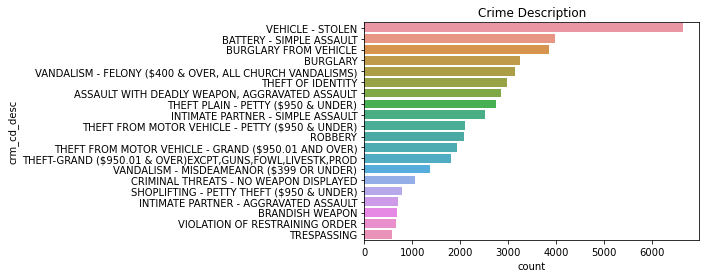

In [132]:
sns.countplot(y = 'crm_cd_desc', order=df.crm_cd_desc.value_counts().iloc[:20].index, data=df).set_title('Crime Description')

Text(0.5, 1.0, 'Crime Scene')

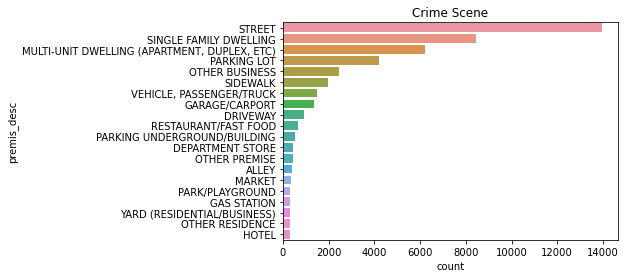

In [131]:
sns.countplot(y = 'premis_desc', order=df.premis_desc.value_counts().iloc[:20].index, data=df).set_title('Crime Scene')

Text(0.5, 1.0, 'Victim Race')

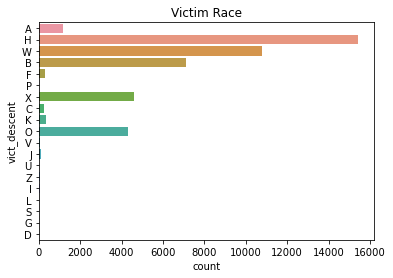

In [129]:
sns.countplot(y = 'vict_descent', data=df).set_title('Victim Race')

<AxesSubplot:xlabel='count', ylabel='area_name'>

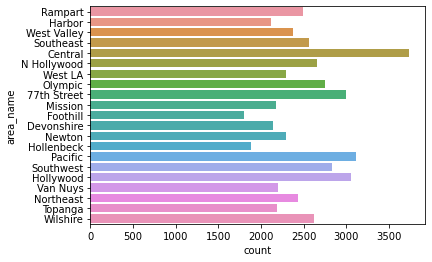

In [116]:
sns.countplot(y = 'area_name', data=df)